# Block Model using `SimPEG`



Note on environment: running `simulation` branch of SimPEG

In [1]:
# core python libraries we rely on
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# SimPEG ecosystem 
import discretize
from discretize.utils import mkvc
from SimPEG.electromagnetics import frequency_domain as fdem
from pymatsolver import Pardiso
import ipywidgets
%load_ext memory_profiler

## load the model and survey

In [2]:
# 1D background
depth = [0., -600, -850, -3150]
res1d = [1e8, 0.3, 1, 2, 1000]
aniso = [1, 1, 1, np.sqrt(2), 1]

# Define dimensions of the three blocks [x1, x2, y1, y2, z1, z2]
block1 = [ -500,  500, -4000, 4000,  -1600, -850]
block2 = [    0, 5000, -3000,    0,  -1850, -1600]
block3 = [-5000,    0,     0, 3000, -2900, -1600]

# Resistivities Block 1, 2, and 3
resistivities = [10, 100, 500]

In [3]:
ds = xr.load_dataset('../block_model_and_survey.nc', engine='h5netcdf')

In [4]:
hx, hy, hz = ds.attrs['hx'], ds.attrs['hy'], ds.attrs['hz']
x0 = ds.attrs['x0']
mesh_model = discretize.TensorMesh([hx, hy, hz], x0=x0)

mesh_model

TensorMesh: 288 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x      6    -10,000.00     10,000.00    500.00  5,000.00    9.00
   y      6    -10,000.00     10,000.00  1,000.00  6,000.00    6.00
   z      8     -3,400.00        500.00    250.00  1,050.00    4.20

In [5]:
resh_bg, resv_bg = ds.attrs['resh_bg'], ds.attrs['resv_bg']
resh_tg, resv_bg = ds.attrs['resh_tg'], ds.attrs['resv_tg']

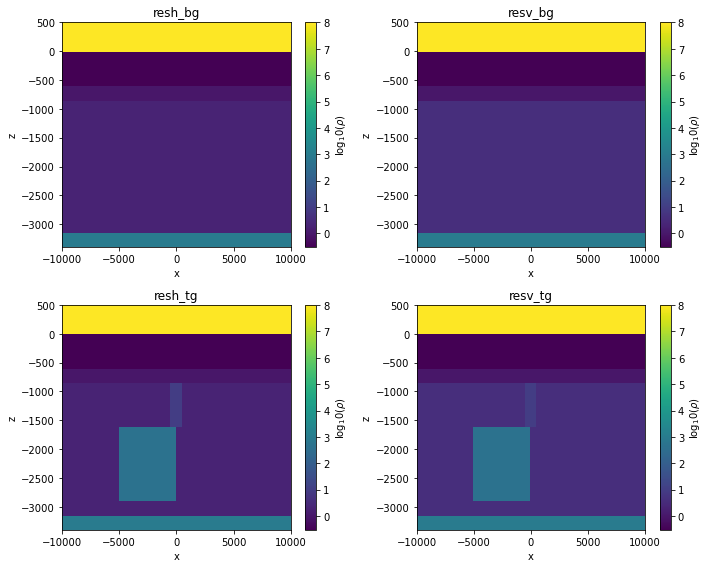

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for a, m in zip(ax.flatten(), ['resh_bg', 'resv_bg', 'resh_tg', 'resv_tg']):
    cb = plt.colorbar(
        mesh_model.plotSlice(np.log10(ds.attrs[m]), ax=a, normal='Y')[0], ax=a
    )
    a.set_title(m)
    cb.set_label("log$_10$($\\rho$)")

plt.tight_layout()

In [7]:
# Get Survey
src = ds.attrs['src']
strength = ds.attrs['strength']
freq = ds.attrs['freq']
rec_x = ds.x.data[::2]
rec_y = ds.attrs['rec_y']
rec_z = ds.attrs['rec_z'] - 0.1
rx_locs = discretize.utils.ndgrid([rec_x, rec_y, np.r_[rec_z]])

# Get source center (for meshing)
src_c = np.mean(src.reshape(-1, 2), 1)
print(src)

[-100.  100.    0.    0. -550. -550.]


In [8]:
print(
    f"skin depth: {503/np.sqrt(freq/np.unique(resh_bg))}"
)

skin depth: [2.75504446e+02 5.03000000e+02 7.11349422e+02 1.59062566e+04
 5.03000000e+06]


## create a computational mesh

In [9]:
# use the same discretization and domain extent in each dimension
dx, dy, dz = 100, 100, 50 
domain_x, domain_y, domain_z = 2e4, 6e3, np.abs(depth).max()

ncore_x = domain_x/dx
ncore_y = domain_y/dy
ncore_z = domain_z/dz

print(ncore_x, ncore_y, ncore_z, ncore_x*ncore_y*ncore_z)

npad_x = 20
npad_y = 20
npad_z = 20

ncx = 2**int(np.ceil(np.log(ncore_x + npad_x*2)/np.log(2.)))
ncy = 2**int(np.ceil(np.log(ncore_y + npad_y*2)/np.log(2.)))
ncz = 2**int(np.ceil(np.log(ncore_z + npad_z*2)/np.log(2.)))

print(ncx, ncy, ncz, ncx*ncy*ncz)

# npad_x = int((ncx - ncore_x)/2)
# npad_y = int((ncy - ncore_y)/2)
# npad_z = int((ncz - ncore_z)/2)

pf = 1.4


200.0 60.0 63.0 756000.0
256 128 128 4194304


In [10]:
# define the base mesh
def make_mesh(refine_blocks = False):
    mesh = discretize.TreeMesh(
        [
            [(dx, npad_x, -pf), (dx, ncx-npad_x*2), (dx, npad_x, pf)], 
            [(dy, npad_y, -pf), (dy, ncy-npad_y*2), (dy, npad_y, pf)], 
            [(dz, npad_z, -pf), (dz, ncz-npad_z*2), (dz, npad_z, pf)]
        ]
    )

    mesh.x0 = np.r_[
        -np.sum(mesh.h[0])/2., -np.sum(mesh.h[1])/2., -np.sum(mesh.h[2][:ncz-npad_z])
    ]


    # refine around the layers 
    xrefine = 2.25*domain_x*np.r_[-1, 1]
    yrefine = 1.5*domain_x*np.r_[-1, 1]

    for d in depth: 
        xr, yr, zr = np.meshgrid(xrefine, yrefine, np.r_[d])
        surface_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]
        mesh = discretize.utils.refine_tree_xyz(
            mesh, surface_refine, 
            octree_levels=[1, 1], method="surface", finalize=False
        )

    # refine around the sources and receivers
    xr, yr, zr = np.meshgrid(src[0:2], src[2] + dy/2*np.r_[-1, 1], src[4] + dz/2*np.r_[-1, 1]) 
    src_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]
    mesh = discretize.utils.refine_tree_xyz(
        mesh, src_refine, 
        octree_levels=[4, 4, 2], method="box", finalize=False
    )

    mesh = discretize.utils.refine_tree_xyz(
        mesh, rx_locs, 
        octree_levels=[4, 4, 2], method="radial", finalize=False
    )

    if refine_blocks:
        # refine around the blocks
        for b in [block1, block2, block3]:
            for xb, yb, zb in zip(
                [b[0], b[1], b[0:2], b[0:2], b[0:2], b[0:2]], # x
                [b[2:4], b[2:4], b[2], b[3], b[2:4], b[2:4]], # y
                [b[4:6], b[4:6], b[4:6], b[4:6], b[4], b[5]]  # z
            ):
                if not isinstance(xb, list):
                    xb = xb + 2*dx*np.r_[-1, 1]
                elif not isinstance(yb, list): 
                    yb = yb + 2*dy*np.r_[-1, 1]
                elif not isinstance(zb, list): 
                    zb = zb + 2*dz*np.r_[-1, 1]

                xr, yr, zr = np.meshgrid(xb, yb, zb) 
                surface_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]
                mesh = discretize.utils.refine_tree_xyz(
                    mesh, surface_refine, 
                    octree_levels=[1, 1, 1],
                    method="box", finalize=False
                )

    mesh.finalize()
    
    return mesh

In [11]:
mesh_b = make_mesh(False)
mesh_t = make_mesh(True)

In [12]:
print(mesh_b.nC, mesh_t.nC)

397840 453154


In [13]:
mesh_b

OcTreeMesh: 9.49% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  4   :       128            ---------------------------   --------------------
  5   :      2312         x: -303288.89398849645,303288.89398849645     100.0   , 291494.33398849645
  6   :      22408        y: -296888.8939884965,296888.8939884964     100.0   , 291494.33398849645
  7   :      97024        z: -150644.44699424822,146244.44699424822      50.0   , 145747.16699424823
  8   :     275968     
-----------------------
Total :     397840

In [14]:
mesh_t

OcTreeMesh: 10.80% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  4   :       128            ---------------------------   --------------------
  5   :      2272         x: -303288.89398849645,303288.89398849645     100.0   , 291494.33398849645
  6   :      21414        y: -296888.8939884965,296888.8939884964     100.0   , 291494.33398849645
  7   :     100988        z: -150644.44699424822,146244.44699424822      50.0   , 145747.16699424823
  8   :     328352     
-----------------------
Total :     453154

(<matplotlib.cm.ScalarMappable at 0x2aed2d4af350>,)

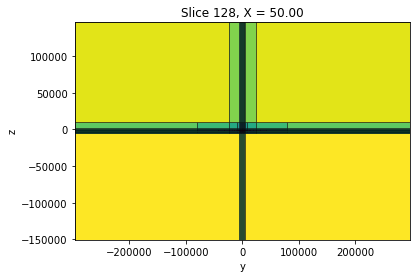

In [15]:
fig, ax = plt.subplots(1, 1)
mesh_b.plotSlice(np.log10(mesh_b.vol), normal='x', grid=True, ax=ax)
# ax.set_xlim([-10000, 10000])
# ax.set_ylim([-4000, 100])

In [16]:
def plot_mesh(normal="Y", ind=1024, xmin=-10000, xmax=10000, ymin=-4000, ymax=100):
    fig, ax = plt.subplots(1, 1)
    mesh_b.plotSlice(np.log10(mesh_b.vol), normal=normal, grid=True, ax=ax, ind=ind)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

In [17]:
max_h = np.max([len(h) for h in mesh_b.h])
ipywidgets.interact(
    plot_mesh,
    normal=ipywidgets.ToggleButtons(options=["X", "Y", "Z"], value="Y"),
    ind=ipywidgets.IntSlider(min=0, max=max_h, value=int(len(mesh_b.h[1])/2)),
    xmin=ipywidgets.FloatText(value=-domain_x),
    xmax=ipywidgets.FloatText(value=domain_x),
    ymin=ipywidgets.FloatText(value=-4000),
    ymax=ipywidgets.FloatText(value=100)
)

interactive(children=(ToggleButtons(description='normal', index=1, options=('X', 'Y', 'Z'), value='Y'), IntSli…

<function __main__.plot_mesh(normal='Y', ind=1024, xmin=-10000, xmax=10000, ymin=-4000, ymax=100)>

### put the model on the computational mesh

In [18]:
def build_model(mesh, blocks=False): 
    rhoh = res1d[0]*np.ones(mesh.nC)
    rhov = res1d[0]*np.ones(mesh.nC)
    
    for r, a, d in zip(res1d[1:], aniso[1:], depth):
        inds = mesh.gridCC[:, 2] <= d 
        rhoh[inds] = r
        rhov[inds] = r*a**2
    
    # find the cells where we have coarsened over an interface
    inds_outside_domain = (
        (mesh.gridCC[:, 0] <= -domain_x) | (mesh.gridCC[:, 0] >= domain_x) |
        (mesh.gridCC[:, 1] <= -domain_y) | (mesh.gridCC[:, 1] >= domain_y) |
        (mesh.gridCC[:, 2] <= -domain_z)
    )

    cell_tops = mesh.gridCC[:, 2] + mesh.h_gridded[:, 2]/2
    cell_bottoms = mesh.gridCC[:, 2] - mesh.h_gridded[:, 2]/2

    inds_crossing_layers = np.zeros(mesh.nC, dtype=bool)
    layer_inds_crossed = 999 * np.ones(mesh.nC, dtype=int)
    for i, d in enumerate(depth):
        crossing_layer = ((d < cell_tops) & (d > cell_bottoms))
        layer_inds_crossed[crossing_layer] = i
        inds_crossing_layers = inds_crossing_layers | crossing_layer

    inds_to_average = inds_outside_domain & inds_crossing_layers

    for i in np.where(inds_to_average)[0]:
        cell_top = cell_tops[i]
        cell_bottom = cell_bottoms[i]
        d = depth[layer_inds_crossed[i]]
        
        rhoha = res1d[layer_inds_crossed[i]]
        rhohb = res1d[layer_inds_crossed[i]+1]
        
        rhova = res1d[layer_inds_crossed[i]] * aniso[layer_inds_crossed[i]]
        rhovb = res1d[layer_inds_crossed[i]+1] * aniso[layer_inds_crossed[i]+1]**2
        
        rhoh[i] = 1./(
            (1./rhoha * (cell_top - d) + 1./rhohb * (d - cell_bottom)) / (cell_top - cell_bottom)
        )
        rhov[i] = (
            (rhova * (cell_top - d) + rhovb * (d - cell_bottom)) / (cell_top - cell_bottom)
        )
        
#         rhoh[i] = np.exp(
#             (np.log(rhoha) * (cell_top - d) + np.log(rhohb) * (d - cell_bottom)) / (cell_top - cell_bottom)
#         )
#         rhov[i] = np.exp(
#             (np.log(rhova) * (cell_top - d) + np.log(rhovb) * (d - cell_bottom)) / (cell_top - cell_bottom)
#         )
    
    if blocks: 
        for r, b in zip(resistivities, [block1, block2, block3]):
            inds = (
                (mesh.gridCC[:, 0] >= b[0]) & (mesh.gridCC[:, 0] <= b[1]) &
                (mesh.gridCC[:, 1] >= b[2]) & (mesh.gridCC[:, 1] <= b[3]) &
                (mesh.gridCC[:, 2] >= b[4]) & (mesh.gridCC[:, 2] <= b[5])
            )
            rhoh[inds] = r
            rhov[inds] = r
    
    return rhoh, rhov

In [19]:
rhoh_b, rhov_b = build_model(mesh_b, False)
rhoh_t, rhov_t = build_model(mesh_t, True)

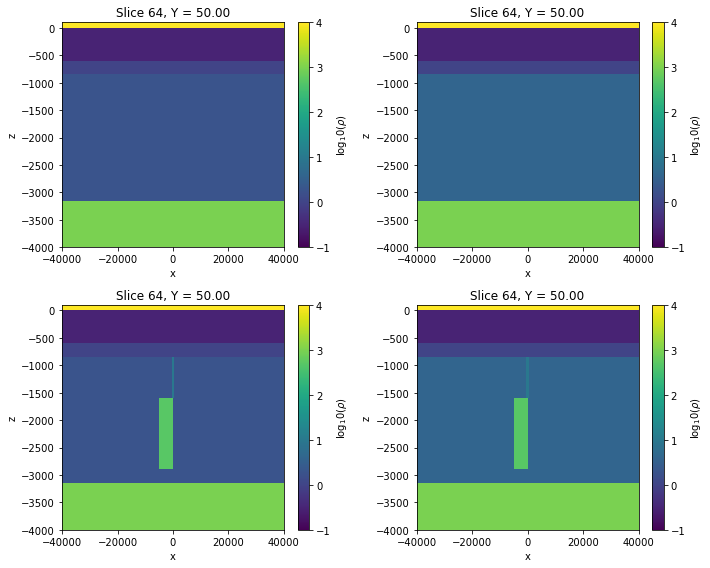

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for a, m, mesh in zip(ax.flatten(), [rhoh_b, rhov_b, rhoh_t, rhov_t], [mesh_b, mesh_b, mesh_t, mesh_t]):
    cb = plt.colorbar(
        mesh.plotSlice(np.log10(m), ax=a, normal='Y', pcolorOpts={"vmin":-1, "vmax":4})[0], ax=a
    )
    cb.set_label("log$_10$($\\rho$)")
    a.set_xlim(2*domain_x*np.r_[-1, 1])
    a.set_ylim([-4000, 100])

plt.tight_layout()

In [21]:
rho_b = np.vstack([rhoh_b, rhoh_b, rhov_b]).T
rho_t = np.vstack([rhoh_t, rhoh_t, rhov_t]).T

## set up the frequency domain simulation

In [22]:
rx_re = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="real")
rx_im = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="imag")

In [23]:
def build_source(mesh): 
    src_x = np.zeros(mesh.nEx)
    src_inds = (
        (mesh.gridEx[:, 0] >= src[0] - 1) & (mesh.gridEx[:, 0] <= src[1] + 1) &
        (mesh.gridEx[:, 1] >= src[2] - 1) & (mesh.gridEx[:, 1] <= src[3] + 1) &
        (mesh.gridEx[:, 2] >= src[4] - 1) & (mesh.gridEx[:, 2] <= src[5] + 1) 
    )
    src_x[src_inds] = 1
    print(src_inds.nonzero())

    src_vec = strength * mesh.edge * np.hstack([
        src_x, np.zeros(mesh.nEy), np.zeros(mesh.nEz)
    ])
    source = fdem.sources.RawVec_e(s_e=src_vec, freq=freq, receiver_list=[rx_re, rx_im])
    return source

In [24]:
source_b = build_source(mesh_b)
source_t = build_source(mesh_t)

(array([144287, 144954]),)
(array([169497, 170803]),)


In [25]:
survey_b = fdem.Survey([source_b])
survey_t = fdem.Survey([source_t])

In [26]:
sim_b = fdem.Simulation3DElectricField(
    mesh=mesh_b, solver=Pardiso, solverOpts={"is_symmetric":True}, survey=survey_b, rho=rho_b
)
sim_t = fdem.Simulation3DElectricField(
    mesh=mesh_t, solver=Pardiso, survey=survey_t, rho=rho_t
)

In [27]:
sim_b.solver

pymatsolver.direct.Pardiso

In [28]:
%%time
mem_b = %memit -o fields_b = sim_b.fields()
ram_b = f"{(mem_b.mem_usage[0] - mem_b.baseline)/1024:.3f} GiB"
print(f"memory usage: {ram_b}")

peak memory: 13404.03 MiB, increment: 11023.47 MiB
memory usage: 10.765 GiB
CPU times: user 6min 34s, sys: 6.32 s, total: 6min 40s
Wall time: 6min 40s


In [29]:
# %%time
# mem_t = %memit -o fields_t = sim_t.fields()
# ram_t = f"{(mem_t.mem_usage[0] - mem_t.baseline)/1024:.3f} GiB"
# print(f"memory usage: {ram_t}")

In [30]:
# sim_b.survey = survey_b
d_b = sim_b.dpred(f=fields_b)
# d_t = sim_t.dpred(f=fields_t)

In [31]:
def get_data_lines(fields, mesh):
    
    data = []
    
    every_other = np.zeros(mesh.nEx, dtype=bool)
#     every_other[::2] = True
    x_inds = ((mesh.gridEx[:, 0] >= rec_x.min() - 1) & (mesh.gridEx[:, 0] <= rec_x.max() + 1))
    z_inds = (mesh.gridEx[:, 2] >= rec_z - 1) & (mesh.gridEx[:, 2] <= rec_z + 1)
    
    for y in rec_y: 
        y_inds = (mesh.gridEx[:, 1] >= y - 1) & (mesh.gridEx[:, 1] <= y + 1)
        inds_x = x_inds & y_inds & z_inds
        inds = np.hstack([inds_x, np.zeros(mesh.nEy, dtype=bool), np.zeros(mesh.nEz, dtype=bool) ])
        
        data.append(fields[:, "e"][inds])
    
    x = mesh.gridEx[inds_x, 0]
    return x, data   

In [32]:
x, data_b = get_data_lines(fields_b, mesh_b)
# x, data_t = get_data_lines(fields_t)

In [33]:
# reshape data to desired shape

def get_data_lines(data): 
    d_re = data[:rx_locs.shape[0]]
    d_im = data[rx_locs.shape[0]:]

    d_line1 = np.vstack([d_re[:101], d_im[:101]]).T
    d_line2 = np.vstack([d_re[101:202], d_im[101:202]]).T
    d_line3 = np.vstack([d_re[202:], d_im[202:]]).T
    
    return [d_line1, d_line2, d_line3]

data_b_lines = get_data_lines(d_b)
# data_t_lines = get_data_lines(d_t)

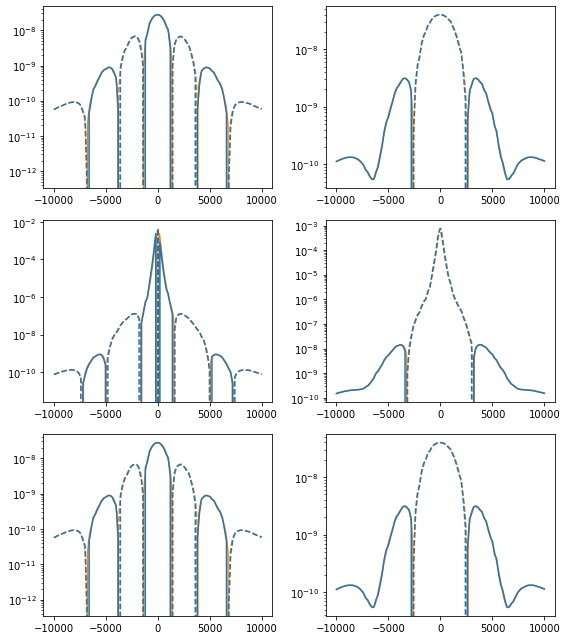

In [34]:
fig, ax = plt.subplots(3, 2, figsize=(8, 9))

for i, d in enumerate(data_b):
    for j, comp in enumerate(["real", "imag"]):
        ax[i, j].semilogy(x, getattr(d, comp), "C1-")
        ax[i, j].semilogy(x, -getattr(d, comp), "C1--")

for i, d in enumerate(data_b_lines):
    for j, comp in enumerate(["real", "imag"]):
        ax[i, j].semilogy(rec_x, d[:, j], "C0-")
        ax[i, j].semilogy(rec_x, -d[:, j], "C0--")

plt.tight_layout()

In [35]:
# fig, ax = plt.subplots(3, 2, figsize=(8, 9))

# for i, d in enumerate(data_t_lines):
#     for j, comp in enumerate(["real", "imag"]):
#         ax[i, j].semilogy(rec_x, d[:, j], "C0-")
#         ax[i, j].semilogy(rec_x, -d[:, j], "C0--")

# plt.tight_layout()

In [36]:
def extract_lines(name):
    import xarray as xr
    inp = xr.load_dataset(name, engine='h5netcdf')
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out

epm_1d = extract_lines('../results/layered_empymod.nc')

In [37]:
epm_1d.shape

(101, 3)

In [38]:
def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

In [39]:
# Calculate error
error = {}
spg_data = np.vstack([d[:, 0] + 1j*d[:, 1] for d in data_b_lines]).T

# spg_data = np.vstack(data_back_lines).T
for name, data in zip(['SimPEG'], [spg_data]):
    rerr = np.clip(100*abs((epm_1d.real-data.real)/epm_1d.real), 0.01, 100)
    ierr = np.clip(100*abs((epm_1d.imag-data.imag)/epm_1d.imag), 0.01, 100)
    error[name] = rerr + 1j*ierr

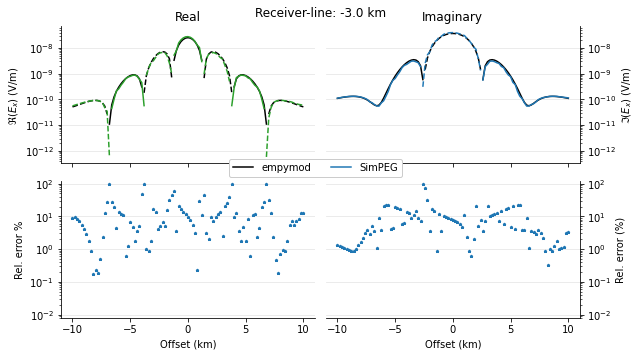

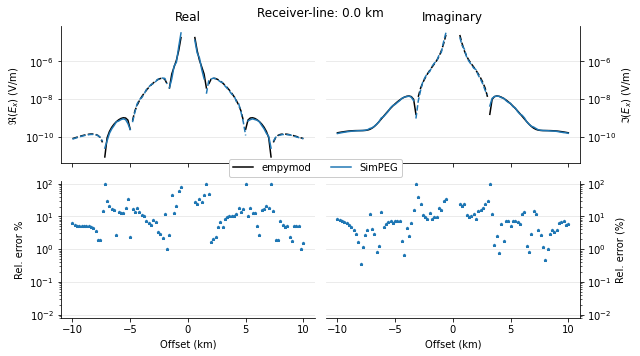

In [40]:
marker = ['*', 'v', '^', 'o']
min_offset = 500

for iy, y in enumerate(rec_y[:2]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + y**2)

    plt.figure(figsize=(9, 5))

    # # Real
    ax1 = plt.subplot(221)
    plt.title('Real')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)


    plt.ylabel(r'$\Re(E_x)$ (V/m)')
    ax1.set_xticklabels([])
    plt.grid(axis='y', c='0.9')


    # # Real Error
    ax2 = plt.subplot(223)

    for i, name in enumerate(error.keys()):
        error[name][off < min_offset, iy] = np.nan + 1j*np.nan
        plt.plot(rec_x/1e3, error[name][:, iy].real, f'C{i}{marker[i]}', ms=3)

    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.ylabel('Rel. error %')
#     plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    plt.grid(axis='y', c='0.9')
    plt.xlabel('Offset (km)')


    # # Imaginary
    ax3 = plt.subplot(222, sharey=ax1)
    plt.title('Imaginary')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)
    
    plt.yscale('log')
    plt.ylabel(r'$\Im(E_x)$ (V/m)')

    ax3.set_xticklabels([])
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')


    # # Imaginary Error
    ax4 = plt.subplot(224, sharey=ax2)

    for i, name in enumerate(error.keys()):
        plt.plot(rec_x/1e3, error[name][:, iy].imag, f'C{i}{marker[i]}', ms=3)

    # Legend
    plt.plot(0, -1, 'k', label='empymod')
    for i, name in enumerate(error.keys()):
        plt.plot(0, -1, f'C{i}', label=name)
        
    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.xlabel('Offset (km)')
    plt.ylabel('Rel. error (%)')
    plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')

    # Switch off spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.legend(loc=2, ncol=2, bbox_to_anchor=(-0.4, 1.2), framealpha=1)
    
    #plt.savefig(f'../manuscript/figures/results-layered-{int(y/1e3)}.pdf', bbox_inches='tight')
    plt.suptitle(f'Receiver-line: {y/1e3} km')
    plt.show()

In [41]:
for i in range(3):
    print(f"Line {i}")
    inds = ~ np.isnan(error['SimPEG'][:, i])
    print(f"mean real: {np.mean(error['SimPEG'][inds, i].real):1.2f}, imag: {np.mean(error['SimPEG'][inds, i].imag):1.2f}")
    print(f"median  real: {np.median(error['SimPEG'][inds, i].real):1.2f}, imag: {np.median(error['SimPEG'][inds, i].imag):1.2f}")             
    print("\n")
                  

Line 0
mean real: 14.02, imag: 9.02
median  real: 7.17, imag: 4.79


Line 1
mean real: 16.04, imag: 10.57
median  real: 9.65, imag: 6.89


Line 2
mean real: 14.02, imag: 9.02
median  real: 7.18, imag: 4.79




In [42]:
import pymatsolver